In [222]:
import pandas as pd
import re
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
from sklearn.preprocessing import (
    FunctionTransformer,
    RobustScaler,
    OneHotEncoder,
    OrdinalEncoder,
    LabelEncoder   
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import (
    train_test_split,
    RepeatedStratifiedKFold,
    cross_val_score
)
from sklearn.cluster import DBSCAN
from xgboost import XGBRegressor
from sklearn.ensemble import IsolationForest
import optuna
import datetime as dt

In [223]:
df = pd.read_excel('../data/Real estate valuation data set.xlsx', index_col='No')

In [224]:
df.columns

Index(['X1 transaction date', 'X2 house age',
       'X3 distance to the nearest MRT station',
       'X4 number of convenience stores', 'X5 latitude', 'X6 longitude',
       'Y house price of unit area'],
      dtype='object')

In [225]:
pattern = re.compile(r'X(\d+)\s|Y\s')
df.columns = list(map(lambda x: 
                            pattern.sub('', x)
                            .lower().replace(' ', '_'),
                    df.columns.values))



In [226]:
df.head()

,transaction_date,house_age,distance_to_the_nearest_mrt_station,number_of_convenience_stores,latitude,longitude,house_price_of_unit_area
No,,,,,,,
1,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9
2,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2
3,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3
4,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8
5,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1


In [227]:
df.reset_index(inplace=True)
df.drop(columns='No', inplace=True)

In [228]:
df['transaction_date'] = df['transaction_date'].copy().astype('int').astype('category')

In [229]:
df.nunique()

transaction_date                         2
house_age                              236
distance_to_the_nearest_mrt_station    259
number_of_convenience_stores            11
latitude                               234
longitude                              232
house_price_of_unit_area               270
dtype: int64

In [230]:
metadata = {
    'tgt': 'house_price_of_unit_area',
    'num_fts': df.select_dtypes(include='number').columns.tolist(),
    'cat_fts': df.select_dtypes(include='category').columns.tolist(),   
    'n_cols': df.shape[1]
}
metadata

{'tgt': 'house_price_of_unit_area',
 'num_fts': ['house_age',
  'distance_to_the_nearest_mrt_station',
  'number_of_convenience_stores',
  'latitude',
  'longitude',
  'house_price_of_unit_area'],
 'cat_fts': ['transaction_date'],
 'n_cols': 7}

In [231]:
def generate_fig(n_df_cols, fig_cols=3):
    fig_rows = (len(n_df_cols) // fig_cols) + 1 if len(n_df_cols) % fig_cols != 0 else len(n_df_cols) // fig_cols
    return fig_rows, fig_cols

In [232]:
fig_rows, fig_cols = generate_fig(metadata['num_fts'])

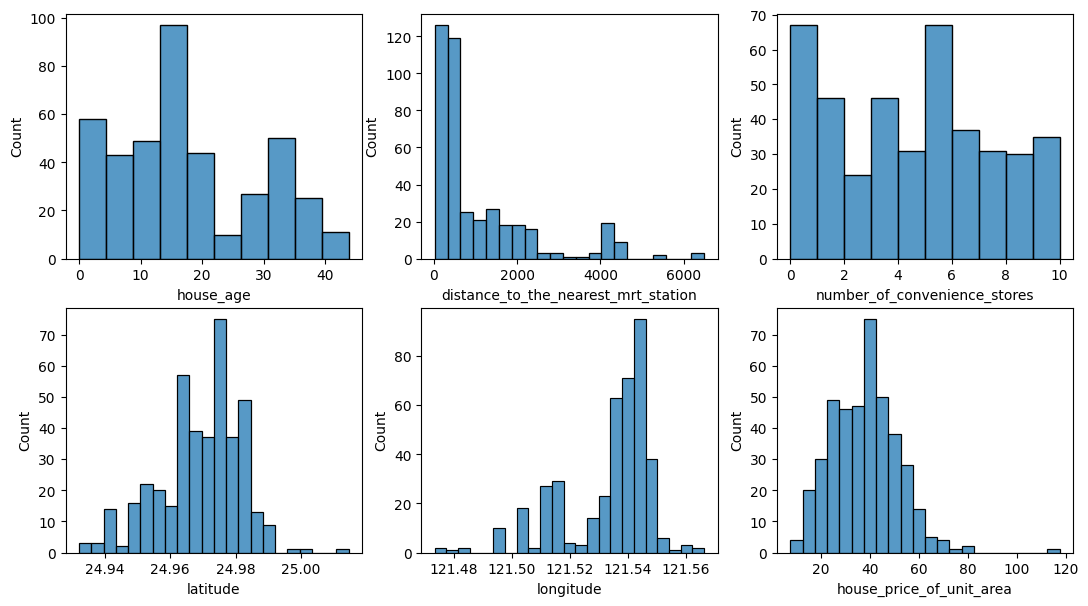

In [233]:
fig, axes = plt.subplots(fig_rows, fig_cols, figsize=(13, 7))

for i, col in enumerate(metadata['num_fts']):
    subp_col = i % fig_cols 
    subp_row = i // fig_cols 
    sns.histplot(df[col], ax=axes[subp_row, subp_col])



In [234]:
tsne = TSNE(n_components=3)

df_tsne = pd.DataFrame(
    data=tsne.fit_transform(df[metadata['num_fts']]),
    columns=tsne.get_feature_names_out()
)

,tsne0,tsne1,tsne2
0,-17.527323,-4.628499,1.395050
1,-6.504704,7.019527,-0.360789
2,-0.588382,-6.289502,3.491259
3,-0.588657,-6.304324,3.562763
4,-3.208351,3.865167,3.905588


In [235]:
fig = px.scatter_3d(
    data_frame=df_tsne,
    x=df_tsne.columns[0],
    y=df_tsne.columns[1],
    z=df_tsne.columns[2],
    opacity=0.5,
)
fig.show()

In [236]:
scaler = RobustScaler()

In [237]:
isf = IsolationForest(contamination=0.05)
outliers = isf.fit_predict(scaler.fit_transform(df.drop(columns=metadata['tgt'])))
outliers

array([ 1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
        1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1, -1,  1,  1,  1, -1,  1,  1,  1, -1,  1,  1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

In [238]:
df_tsne['outliers'] = outliers.astype(str)
fig = px.scatter_3d(
    data_frame=df_tsne,
    x=df_tsne.columns[0],
    y=df_tsne.columns[1],
    z=df_tsne.columns[2],
    color='outliers',
    color_discrete_map={
        '-1': 'red',
        '1': 'grey'
    }
)
fig.show()

In [ ]:
metadata['num_fts'] != metadata['tgt']

True